In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
import IPython.display as ipd
import librosa
import sklearn.preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, InputLayer, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D


/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow_io/core/python/ops/__init__.py:103: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow_io/core/python/ops/libtensorflow_io.so']
caused by: ['/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow_io/core/python/ops/libtensorflow_io.so: undefined symbol: _ZN10tensorflow2io20InputStreamInterface10SkipNBytesEl']
  warnings.warn("file system plugins are not loaded: {}".format(e))


In [578]:
def get_paths_and_labels(audio_directory_path):
#     class_names = os.listdir(audio_directory_path)
    class_names = ['english', 'spanish', 'mandarin']
#     class_names.remove('.DS_Store')
    label_class_dict = {num:class_ for num, class_ in enumerate(class_names)}
    
    audio_paths = []
    labels = []

    for label, name in enumerate(class_names):
        dir_path = os.path.join(audio_directory_path, name)
        full_paths = [os.path.join(dir_path, filename) for filename in os.listdir(dir_path) if 'ipynb' not in filename and '.DS_Store' not in filename]
        audio_paths += full_paths
        labels += [label] * len(full_paths)
    
    return audio_paths, labels, label_class_dict

def path_to_mfcc(path):
    audio, sr = librosa.load(path, sr=None)
    mfcc = librosa.feature.mfcc(audio, sr, n_fft=1024,
                                    n_mfcc=40, n_mels=40,
                                    hop_length=256)
#     mfcc = librosa.feature.delta(mfcc, order=2)
    mfccs = mfcc.copy()
    mfccs.T
    mfccs.resize((6000, 40), refcheck=False)
#     mfccs = sklearn.preprocessing.scale(mfccs)
    return mfccs

def create_dataset(audio_paths, labels):
    X = np.zeros((len(audio_paths), 6000, 40))
    for idx, file in enumerate(audio_paths):
        X[idx] = path_to_mfcc(file)
    y = np.array(labels)
    return tf.data.Dataset.from_tensor_slices((X, y))

In [579]:
train_path = '../../data/cleaned_set_44/cleaned_set_train'
test_path = '../../data/cleaned_set_44/cleaned_set_test'

In [580]:
batch_size = 16

train_audio_paths, train_labels, train_label_class_dict = get_paths_and_labels(train_path)
train_ds = create_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=len(train_ds)).batch(batch_size)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

test_audio_paths, test_labels, test_label_class_dict = get_paths_and_labels(test_path)
test_ds = create_dataset(test_audio_paths, test_labels)
test_ds = test_ds.shuffle(buffer_size=len(test_ds)).batch(batch_size)
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [178]:
test_label_class_dict

{0: 'english', 1: 'spanish', 2: 'mandarin'}

In [254]:
import os
root_logdir = os.path.join(os.curdir, "mfcc_3class_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [202]:
model=Sequential()

model.add(Conv2D(32, (3,1), padding='same', input_shape=(13, 6400, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (2,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 32, 6400, 1)       1280      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 32, 2133, 1)       0         
_________________________________________________________________
dropout_330 (Dropout)        (None, 32, 2133, 1)       0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 64, 2133, 1)       4160      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 64, 711, 1)        0         
_________________________________________________________________
dropout_331 (Dropout)        (None, 64, 711, 1)        0         
_________________________________________________________________
flatten_81 (Flatten)         (None, 45504)           

In [203]:
model_save_filename = 'mfcc_3class_2dcnn_model'

earlystopping_cb = keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)
modelcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor='val_accuracy', save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())

history = model.fit(train_ds, 
                    epochs=100, 
                    validation_data=test_ds,
                    callbacks=[earlystopping_cb, modelcheckpoint_cb, tensorboard_cb])

Epoch 1/100
19/19 [==============================] - 1s 44ms/step - loss: 1.3718 - accuracy: 0.3514 - val_loss: 0.8727 - val_accuracy: 0.5333
INFO:tensorflow:Assets written to: mfcc_3class_2dcnn_model/assets
Epoch 2/100
19/19 [==============================] - 0s 12ms/step - loss: 0.8693 - accuracy: 0.6057 - val_loss: 0.8358 - val_accuracy: 0.5333
Epoch 3/100
19/19 [==============================] - 0s 11ms/step - loss: 0.8917 - accuracy: 0.5803 - val_loss: 0.8280 - val_accuracy: 0.5833
INFO:tensorflow:Assets written to: mfcc_3class_2dcnn_model/assets
Epoch 4/100
19/19 [==============================] - 0s 12ms/step - loss: 0.8920 - accuracy: 0.5119 - val_loss: 0.8226 - val_accuracy: 0.5667
Epoch 5/100
19/19 [==============================] - 0s 11ms/step - loss: 0.8574 - accuracy: 0.5799 - val_loss: 0.8475 - val_accuracy: 0.5500
Epoch 6/100
19/19 [==============================] - 0s 11ms/step - loss: 0.8786 - accuracy: 0.5699 - val_loss: 0.8089 - val_accuracy: 0.5333
Epoch 7/100
19/1

In [581]:
# model = keras.models.Sequential()
# model.add(keras.layers.InputLayer(input_shape=[6000,13]))
# model.add(BatchNormalization())

# model.add(keras.layers.Conv1D(filters=60, kernel_size=3, padding='causal', activation='relu'))
# model.add(Dropout(0.4))
# model.add(MaxPooling1D(pool_size=3, strides=2))
# model.add(keras.layers.Conv1D(filters=60, kernel_size=3, padding='causal', activation='relu'))
# model.add(Dropout(0.4))
# model.add(MaxPooling1D(pool_size=3, strides=2))
# model.add(keras.layers.Conv1D(filters=60, kernel_size=3, padding='causal', activation='relu'))
# model.add(Dropout(0.4))
# model.add(MaxPooling1D(pool_size=3, strides=2))
# model.add(keras.layers.Conv1D(filters=60, kernel_size=3, padding='causal', activation='relu'))
# model.add(Dropout(0.4))
# model.add(MaxPooling1D(pool_size=3, strides=2))
# model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal', activation='relu'))
# model.add(Dropout(0.4))
# model.add(MaxPooling1D(pool_size=2, strides=1))
# model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal', activation='relu'))
# model.add(Dropout(0.4))
# model.add(MaxPooling1D(pool_size=2, strides=1))
# model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal', activation='relu'))
# model.add(Dropout(0.4))
# model.add(MaxPooling1D(pool_size=2, strides=1))
# model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal', activation='relu'))
# model.add(Dropout(0.4))
# model.add(MaxPooling1D(pool_size=2, strides=1))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(.2))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(.2))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(3, activation='softmax'))


# opt = keras.optimizers.Adam(learning_rate=.00001)
# model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.summary()


model=tf.keras.models.Sequential()

model.add(Conv1D(16, 3, strides=2, padding='same', input_shape=(6000, 40), activation='relu'))
model.add(Conv1D(16, 3, strides=2, padding='same', activation='relu'))
model.add(Dropout(.2))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2))

model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(Dropout(.2))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2))

model.add(Conv1D(128, 3, padding='same', activation='relu'))
model.add(Conv1D(128, 3, padding='same', activation='relu'))
model.add(Dropout(.2))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=.0001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()



Model: "sequential_197"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_942 (Conv1D)          (None, 3000, 16)          1936      
_________________________________________________________________
conv1d_943 (Conv1D)          (None, 1500, 16)          784       
_________________________________________________________________
dropout_875 (Dropout)        (None, 1500, 16)          0         
_________________________________________________________________
batch_normalization_129 (Bat (None, 1500, 16)          64        
_________________________________________________________________
max_pooling1d_633 (MaxPoolin (None, 749, 16)           0         
_________________________________________________________________
conv1d_944 (Conv1D)          (None, 749, 32)           1568      
_________________________________________________________________
conv1d_945 (Conv1D)          (None, 749, 32)        

In [582]:
model_save_filename = 'mfcc_3class_model'

earlystopping_cb = keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True)
modelcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor='val_accuracy', save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())

history = model.fit(train_ds, 
                    epochs=1000,
                    validation_data=test_ds,
                    callbacks=[earlystopping_cb, modelcheckpoint_cb, tensorboard_cb])

Epoch 1/1000
19/19 [==============================] - 2s 45ms/step - loss: 2.1880 - accuracy: 0.3927 - val_loss: 0.9870 - val_accuracy: 0.4833
INFO:tensorflow:Assets written to: mfcc_3class_model/assets
Epoch 2/1000
19/19 [==============================] - 1s 24ms/step - loss: 1.2660 - accuracy: 0.5217 - val_loss: 0.9492 - val_accuracy: 0.5500
INFO:tensorflow:Assets written to: mfcc_3class_model/assets
Epoch 3/1000
19/19 [==============================] - 1s 23ms/step - loss: 1.0590 - accuracy: 0.5055 - val_loss: 1.0035 - val_accuracy: 0.5500
Epoch 4/1000
19/19 [==============================] - 1s 21ms/step - loss: 1.0106 - accuracy: 0.5485 - val_loss: 1.0568 - val_accuracy: 0.4667
Epoch 5/1000
19/19 [==============================] - 0s 20ms/step - loss: 1.0367 - accuracy: 0.4891 - val_loss: 0.9960 - val_accuracy: 0.5333
Epoch 6/1000
19/19 [==============================] - 1s 21ms/step - loss: 0.9474 - accuracy: 0.5561 - val_loss: 0.9862 - val_accuracy: 0.5000
Epoch 7/1000
19/19 [==

In [467]:
model.save("final_3_class.h5")

In [123]:
np.argmax(model.predict(test_ds), axis=1)

array([2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 1, 1, 0, 2,
       0, 2, 0, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 0, 2, 2, 1, 0, 0, 0, 2, 0,
       1, 2, 1, 2, 2, 1, 2, 2, 2, 0, 1, 0, 0, 2, 0, 0])

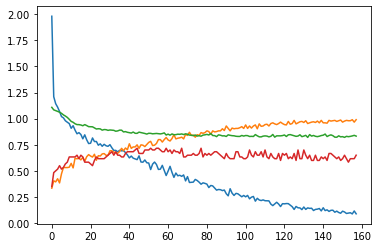

In [267]:
[plt.plot(history.history[x]) for x in history.history.keys()];

In [470]:
plt.style.use('ggplot')

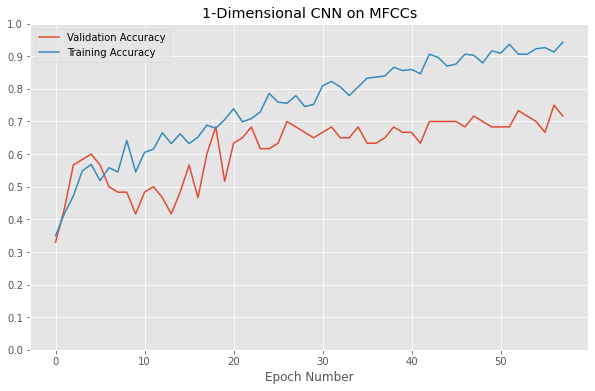

In [524]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot([.33] + history.history['val_accuracy'], label='Validation Accuracy')
ax.plot([.35] + history.history['accuracy'], label='Training Accuracy')
ax.set_xlabel("Epoch Number")
ax.set_ylim(bottom=0)
ax.set_yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.])
ax.set_title("1-Dimensional CNN on MFCCs")
ax.legend();

In [472]:
probabilities = model.predict(test_ds)
y_pred = np.argmax(probabilities, axis=1)

In [474]:
y_true = []
for _, label in test_ds.unbatch():
    y_true.append(label.numpy())

In [295]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [ ]:
total_y_pred = []
total_labels = []

In [531]:
for audios, labels in test_ds.take(1):
    y_pred = model.predict(audios)
    y_pred_labels = np.argmax(y_pred, axis=1)
    print(y_pred_labels)
    print(labels.numpy())

[1 0 1 2 1 0 2 1 0 0 0 0 0 0 2 1]
[1 0 1 1 1 0 2 2 0 0 0 0 0 0 2 2]


In [530]:
print(classification_report(labels.numpy(), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       0.50      0.20      0.29         5
           2       0.50      0.50      0.50         4

    accuracy                           0.62        16
   macro avg       0.57      0.57      0.54        16
weighted avg       0.59      0.62      0.57        16



In [486]:
labels.numpy()

array([1, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 2, 1, 2, 2, 0])

In [535]:
test_audio_paths, test_labels, test_labels_class_dict = get_paths_and_labels(test_path)

In [551]:
y_pred_list = []
y_pred_probabilities = []
for audio_path in test_audio_paths:
    mfcc = path_to_mfcc(audio_path)
    mfcc = mfcc.reshape(1,6000,40)
    y_pred_proba = model.predict(mfcc)
    y_pred = np.argmax(y_pred_proba)
    y_pred_list.append(y_pred)
    y_pred_probabilities.append(y_pred_proba)

In [552]:
print(classification_report(test_labels, y_pred_list))

              precision    recall  f1-score   support

           0       0.64      0.90      0.75        20
           1       0.60      0.45      0.51        20
           2       0.71      0.60      0.65        20

    accuracy                           0.65        60
   macro avg       0.65      0.65      0.64        60
weighted avg       0.65      0.65      0.64        60



In [554]:
my_model = keras.models.load_model("mfcc_3class_model")

In [555]:
y_pred_list = []
y_pred_probabilities = []
for audio_path in test_audio_paths:
    mfcc = path_to_mfcc(audio_path)
    mfcc = mfcc.reshape(1,6000,40)
    y_pred_proba = my_model.predict(mfcc)
    y_pred = np.argmax(y_pred_proba)
    y_pred_list.append(y_pred)
    y_pred_probabilities.append(y_pred_proba)

In [565]:
test_labels_class_dict

{0: 'english', 1: 'spanish', 2: 'mandarin'}

In [575]:
print(classification_report(test_labels, y_pred_list, target_names=["english", "spanish", "mandarin"]))

              precision    recall  f1-score   support

     english       0.74      0.85      0.79        20
     spanish       0.70      0.70      0.70        20
    mandarin       0.82      0.70      0.76        20

    accuracy                           0.75        60
   macro avg       0.75      0.75      0.75        60
weighted avg       0.75      0.75      0.75        60



In [557]:
conf_mat = confusion_matrix(test_labels, y_pred_list)

In [558]:
conf_mat

array([[17,  3,  0],
       [ 3, 14,  3],
       [ 3,  3, 14]])

In [560]:
import seaborn as sns

In [566]:
conf_mat_df = pd.DataFrame(conf_mat, index=['english', 'spanish', 'mandarin'], columns=['english', 'spanish', 'mandarin'])

Text(0.5, 33.0, 'Predicted label')

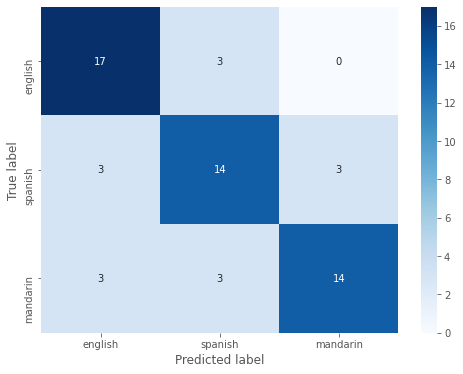

In [570]:
figure = plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_df, annot=True,cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [571]:
incorrect_file_indexes = []
incorrect_probabilities = []
for idx, prediction in enumerate(y_pred_list):
    if prediction != test_labels[idx]:
        incorrect_file_indexes.append(idx)
        incorrect_probabilities.append(y_pred_probabilities[idx])

In [572]:
incorrect_file_indexes

[9, 16, 19, 23, 27, 28, 32, 35, 38, 41, 43, 50, 55, 56, 57]

In [576]:
incorrect_file_names = [test_audio_paths[x] for x in incorrect_file_indexes]

In [577]:
incorrect_file_names

['../../data/cleaned_set_44/cleaned_set_test/english/english216.wav',
 '../../data/cleaned_set_44/cleaned_set_test/english/english33.wav',
 '../../data/cleaned_set_44/cleaned_set_test/english/english563.wav',
 '../../data/cleaned_set_44/cleaned_set_test/spanish/spanish204.wav',
 '../../data/cleaned_set_44/cleaned_set_test/spanish/spanish80.wav',
 '../../data/cleaned_set_44/cleaned_set_test/spanish/spanish24.wav',
 '../../data/cleaned_set_44/cleaned_set_test/spanish/spanish85.wav',
 '../../data/cleaned_set_44/cleaned_set_test/spanish/spanish40.wav',
 '../../data/cleaned_set_44/cleaned_set_test/spanish/spanish51.wav',
 '../../data/cleaned_set_44/cleaned_set_test/mandarin/mandarin43.wav',
 '../../data/cleaned_set_44/cleaned_set_test/mandarin/mandarin40.wav',
 '../../data/cleaned_set_44/cleaned_set_test/mandarin/mandarin25.wav',
 '../../data/cleaned_set_44/cleaned_set_test/mandarin/mandarin9.wav',
 '../../data/cleaned_set_44/cleaned_set_test/mandarin/mandarin19.wav',
 '../../data/cleaned_s

In [574]:
incorrect_probabilities

[array([[0.07103086, 0.88858825, 0.04038089]], dtype=float32),
 array([[0.27022323, 0.46773583, 0.26204103]], dtype=float32),
 array([[0.33677068, 0.3798345 , 0.28339475]], dtype=float32),
 array([[0.98114324, 0.00692125, 0.01193542]], dtype=float32),
 array([[0.02138234, 0.21230365, 0.766314  ]], dtype=float32),
 array([[0.37533244, 0.16593663, 0.458731  ]], dtype=float32),
 array([[0.02691042, 0.08311035, 0.88997924]], dtype=float32),
 array([[9.9835473e-01, 6.3308311e-04, 1.0122445e-03]], dtype=float32),
 array([[0.99619836, 0.00203414, 0.00176744]], dtype=float32),
 array([[0.10450789, 0.5875404 , 0.30795166]], dtype=float32),
 array([[0.93784195, 0.01839231, 0.04376573]], dtype=float32),
 array([[0.75049603, 0.10933165, 0.14017226]], dtype=float32),
 array([[0.01334614, 0.670297  , 0.3163568 ]], dtype=float32),
 array([[0.08417894, 0.67156774, 0.24425326]], dtype=float32),
 array([[0.8337135 , 0.12536836, 0.04091813]], dtype=float32)]